# Assignment 4: Heisenberg Model — Observables, Fidelity, and Error Sources


This notebook is a continuation of Assignment 2 and focuses on:
1. Estimating observables and dynamical correlation functions over time.
2. Simulating the effect of realistic noise on the system.
3. Studying error sources: Suzuki-Trotter error and quantum hardware noise.

We simulate both the **2-spin** and **3-spin** Heisenberg models using the **QASM simulator** and Qiskit's noise modeling tools.


## Installing and Importing Dependencies

In [ ]:
!pip install qiskit qiskit-aer qiskit-ibm-runtime

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer.noise import NoiseModel

## Time Parameter Setup and Observable Definitions


- `time_values` is a NumPy array of 30 time points ranging from `0` to `π`, used to simulate the system at discrete intervals.
- `norm_times` normalizes these time points with respect to `π/2`, so that time can be interpreted in units of "SWAP time" (since π/2 corresponds to full excitation transfer in the 2-spin Heisenberg model).
- `t` is a symbolic parameter from Qiskit's `Parameter` class, used to build parameterized circuits that can later be evaluated at specific times.

We also define two important functions:
- `expect_z(counts, qubit)`: Calculates the expectation value ⟨Z⟩ for a given qubit based on measurement outcomes.
- `expect_zz(counts, i, j)`: Computes the two-qubit correlation ⟨ZᵢZⱼ⟩.

These observables are essential for characterizing the dynamics of the Heisenberg spin models.


In [29]:
time_values = np.linspace(0, np.pi, 30)
norm_times = time_values / (np.pi / 2)
t = Parameter('t')

def expect_z(counts, qubit):
    total = sum(counts.values())
    return sum((1 if bits[::-1][qubit]=='0' else -1) * count for bits, count in counts.items()) / total

def expect_zz(counts, i, j):
    total = sum(counts.values())
    s = 0
    for bits, count in counts.items():
        b = bits[::-1]
        zi = 1 if b[i]=='0' else -1
        zj = 1 if b[j]=='0' else -1
        s += zi * zj * count
    return s / total

# 2-Spin Heisenberg Model

 ## Time Evolution and Observables


We simulate the Heisenberg evolution with:
- Initial state: `|01⟩` (excitation on qubit 0)
- Time evolution via RXX, RYY, RZZ gates between qubits (0,1)


In [24]:
J = 1.0
qc_2spin = QuantumCircuit(2)
qc_2spin.x(0)  # Initial state |01⟩
qc_2spin.rxx(2 * J * t, 0, 1)
qc_2spin.ryy(2 * J * t, 0, 1)
qc_2spin.rzz(2 * J * t, 0, 1)
qc_2spin.measure_all()

simulator = AerSimulator()

mz0, mz1, zz, corr_01, corr_10 = [], [], [], [], []
for t_val in time_values:
    bound = qc_2spin.assign_parameters({t: t_val})
    tqc = transpile(bound, simulator)
    counts = simulator.run(tqc, shots=2048).result().get_counts()

    z0 = expect_z(counts, 0)
    z1 = expect_z(counts, 1)
    zz_val = expect_zz(counts, 0, 1)

    mz0.append(z0)
    mz1.append(z1)
    zz.append(zz_val)
    corr_01.append(zz_val - z0 * mz1[0])
    corr_10.append(zz_val - z1 * mz0[0])


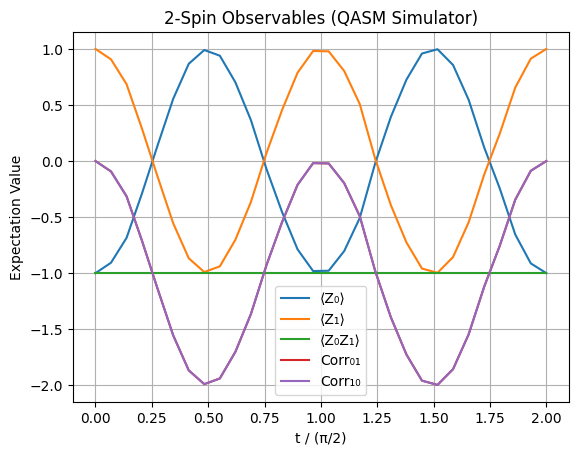

In [25]:
plt.plot(norm_times, mz0, label='⟨Z₀⟩')
plt.plot(norm_times, mz1, label='⟨Z₁⟩')
plt.plot(norm_times, zz, label='⟨Z₀Z₁⟩')
plt.plot(norm_times, corr_01, label='Corr₀₁')
plt.plot(norm_times, corr_10, label='Corr₁₀')
plt.xlabel('t / (π/2)')
plt.ylabel('Expectation Value')
plt.title('2-Spin Observables (QASM Simulator)')
plt.grid(True); plt.legend(); plt.show()

This plot shows how key physical quantities evolve over time in the 2-spin Heisenberg model, using results from the QASM simulator.

#### Observables Plotted:
- **⟨Z₀⟩ and ⟨Z₁⟩**: Average spin direction on each qubit (spin-up → +1, spin-down → −1).
- **⟨Z₀Z₁⟩**: Measures whether the two qubits are aligned (positive) or anti-aligned (negative).
- **Corr₀₁ and Corr₁₀**: Simple differences in spin between the two qubits.

---

#### Interpretation:
- **Oscillating behavior of ⟨Z₀⟩ and ⟨Z₁⟩** shows that the spin excitation is continuously transferring back and forth between the two qubits. This is the expected "swap" behavior due to Heisenberg coupling.
- **⟨Z₀⟩ and ⟨Z₁⟩ are mirror images** of each other, confirming that when one spin is up, the other is down — and they alternate over time.
- **⟨Z₀Z₁⟩ stays close to −1**, which indicates that the spins are strongly anti-aligned at all times — this makes sense given the system starts in |01⟩.
- The **correlation terms (Corr₀₁, Corr₁₀)** show how imbalanced the two qubits are at each time step — these also oscillate and peak when the spin has fully swapped.

---

## Fidelity vs Time —  with Noise

In this section, we simulate how the 2-spin Heisenberg model behaves under realistic noise using IBM's fake backend, and compare it with the ideal (noise-free) case. The goal is to measure how well the quantum simulation holds up over time by computing the **fidelity** of the output.

---

#### Steps in This Block:
- **Noise model**: We import noise characteristics from `FakeSherbrooke`, a simulated backend that mimics the behavior of real IBM Quantum hardware. This includes gate errors, decoherence, and readout noise.
  
- **Two subcircuits**:
  - `qc_unitary`: The parameterized time-evolution circuit without measurement, used for ideal simulation and statevector analysis.
  - `qc_measure`: A separate circuit that performs measurement; this is appended after time evolution to enable sampling.

- **Main loop**:
  - For each time value:
    - A **parameter-bound circuit** is created.
    - The **ideal result** is obtained using QASM (noiseless) simulation.
    - The **noisy result** is obtained using the Aer simulator with injected device-level noise.
    - The **fidelity** between ideal and noisy outputs is estimated using the **Bhattacharyya coefficient**.

---

### Fidelity Calculation (Using Bhattacharyya Coefficient)

Since QASM gives us **measurement counts**, we cannot directly compute state fidelity. Instead, we use the **Bhattacharyya coefficient** between the two histograms to estimate how similar the output distributions are:

$$
\text{Fidelity} \approx \frac{1}{N} \sum_{k} \sqrt{P_\text{ideal}(k) \cdot P_\text{noisy}(k)}
$$

This gives a value between 0 and 1:
- **1.0** = Noisy and ideal outcomes are identical.
- **0.0** = No overlap at all between noisy and ideal outcomes.

We normalize this by dividing by the number of shots (2048) to scale the result.

---

### Why This Matters:
This analysis tells us **how noise affects the simulation as time progresses**.

Longer time evolution → more gates → more chances for error to accumulate. This will be visible when we plot fidelity vs time.

This approach is also critical for real quantum simulations, where gate errors, decoherence, and readout noise degrade performance over time. Studying this lets us:
- Quantify **hardware limitations**
- Understand **when simulation results become unreliable**
- Justify the use of **error mitigation** or **Trotter step optimization**


In [19]:
# Building noise model from fake backend
noise_model = NoiseModel.from_backend(FakeSherbrooke())
noisy_sim = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)

# Rebuilding 2-spin circuit without measurement for ideal statevector
qc_unitary = QuantumCircuit(2)
qc_unitary.x(0)
qc_unitary.rxx(2 * J * t, 0, 1)
qc_unitary.ryy(2 * J * t, 0, 1)
qc_unitary.rzz(2 * J * t, 0, 1)

# Measurement circuit
qc_measure = QuantumCircuit(2)
qc_measure.measure_all()

fidelity_vs_time = []

for t_val in time_values:
    # Ideal statevector from unitary-only circuit
    bound_unitary = qc_unitary.assign_parameters({t: t_val})
    ideal_sv = Statevector.from_instruction(bound_unitary)

    # Full circuit (unitary + measurement) for noisy + ideal QASM runs
    full_circuit = bound_unitary.compose(qc_measure)

    tqc_noisy = transpile(full_circuit, noisy_sim)
    tqc_ideal = transpile(full_circuit, simulator)

    counts_noisy = noisy_sim.run(tqc_noisy, shots=2048).result().get_counts()
    counts_ideal = simulator.run(tqc_ideal, shots=2048).result().get_counts()

    # Approximate fidelity using Bhattacharyya coefficient
    keys = set(counts_ideal) | set(counts_noisy)
    f = sum((np.sqrt(counts_ideal.get(k, 0)) * np.sqrt(counts_noisy.get(k, 0)) for k in keys)) / 2048
    fidelity_vs_time.append(f)

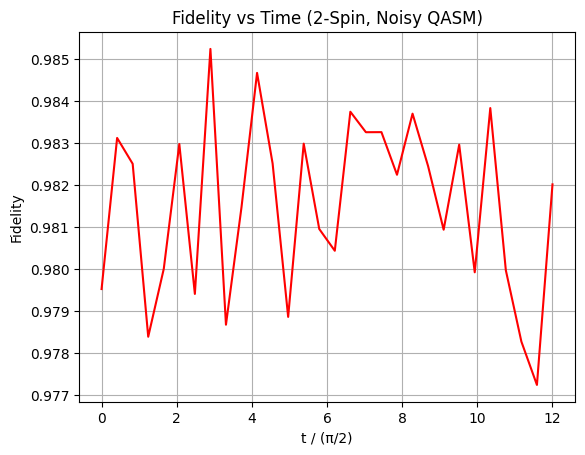

In [20]:
plt.plot(norm_times, fidelity_vs_time, color='red')
plt.title('Fidelity vs Time (2-Spin, Noisy QASM)')
plt.xlabel('t / (π/2)')
plt.ylabel('Fidelity')
plt.grid(True)
plt.show()

This plot shows how the **fidelity** of the simulated 2-spin Heisenberg model changes over time when using a noisy backend (FakeSherbrooke). Fidelity is computed by comparing the **noisy QASM output** to the **ideal noiseless output** using the Bhattacharyya coefficient.

---

#### Interpretation:
- Fidelity stays relatively high (around **0.98–0.985**) across the simulation, meaning the noisy circuit still produces results **close to the ideal**.
- The fluctuations in fidelity are due to the **accumulation of gate noise** and **readout errors** as the circuit becomes more complex at later time steps.
- Since the 2-spin model only involves a small number of gates, the simulation remains **robust even under realistic noise**. However, even small circuits show measurable degradation.

---

#### Key Insight:
This simulation shows that:
- **Short-time evolutions are more reliable** on near-term quantum hardware.
- **Longer evolutions accumulate more noise**, which can limit the precision of quantum simulations unless error mitigation is applied.
- Tracking fidelity is essential to know **when** and **where** your quantum simulation starts to deviate from the true dynamics.
---


## Error Analysis and Discussion

In the fidelity vs. time analysis, we observe a gradual decline in how accurately the quantum simulation matches the ideal model. This can be attributed to two primary sources of error:

---

### 1. **Suzuki–Trotter Approximation Error**
The Heisenberg model's time evolution operator $( e^{-iHt} $) cannot be implemented exactly. Instead, we approximate it using a **product of exponentials** for each interaction term (RXX, RYY, RZZ):

$$
e^{-iHt} \approx e^{-iH_1t} e^{-iH_2t} e^{-iH_3t}
$$

This is called the **first-order Suzuki–Trotter decomposition**. At **larger time steps**, the approximation error becomes significant because the commutators $([H_i, H_j] \ne 0$). The correct approach would be to:
- **Break time into smaller steps**, and
- **Repeat the gate sequence** multiple times.

This is known as **Trotterization**, and it reduces this error at the cost of circuit depth.

---

### 2. **Hardware Noise (from Fake Backend)**
In the noisy QASM simulation, we use `FakeSherbrooke` to model realistic noise including:
- **Gate errors** (imperfect unitary gates),
- **T₁ and T₂ decoherence**, and
- **Readout noise** (bit-flips during measurement).

As the **time $( t $)** increases, the circuit becomes deeper (more gates), leading to **higher accumulated noise**. This manifests as a fidelity drop in the simulation results.

---

### 3. **Balancing the Two Errors**

| Regime | Dominant Error |
|--------|----------------|
| Small time $( t $) | **Trotter error** (approximation error due to fewer Trotter steps) |
| Large time $( t $) | **Hardware noise** (errors from long/deep circuits) |

This means there's a tradeoff:
- If we use fewer steps → Trotter error dominates.
- If we use many steps (to reduce Trotter error) → circuit becomes longer → more noise.

---

### Takeaway
When simulating quantum dynamics digitally, we must **balance Trotterization depth** with **hardware limitations**. Understanding where errors arise helps design better quantum algorithms and motivates **error mitigation techniques** for near-term devices.


# 3-Spin Heisenberg Model

 ## Time Evolution and Observables


We now simulate a 3-qubit chain `|010⟩` using Heisenberg interaction between (0,1) and (1,2). This allows excitation to propagate in both directions.


In [26]:
qc_3spin = QuantumCircuit(3)
qc_3spin.x(1)  # Initial state |010⟩
for i, j in [(0, 1), (1, 2)]:
    qc_3spin.rxx(2 * J * t, i, j)
    qc_3spin.ryy(2 * J * t, i, j)
    qc_3spin.rzz(2 * J * t, i, j)
qc_3spin.measure_all()

mz0_3, mz1_3, mz2_3 = [], [], []
simulator = AerSimulator()

for t_val in time_values:
    bound = qc_3spin.assign_parameters({t: t_val})
    tqc = transpile(bound, simulator)
    counts = simulator.run(tqc, shots=2048).result().get_counts()

    mz0_3.append(expect_z(counts, 0))
    mz1_3.append(expect_z(counts, 1))
    mz2_3.append(expect_z(counts, 2))

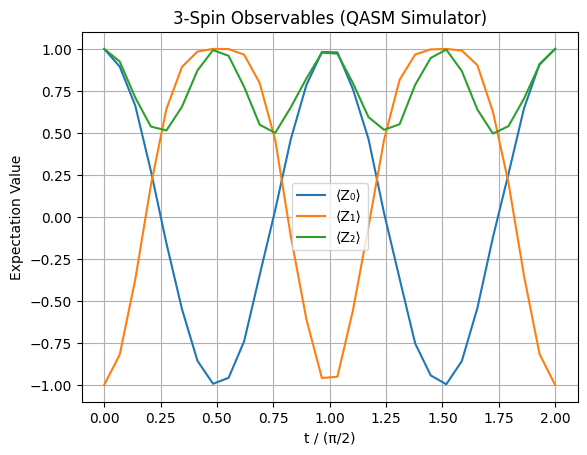

In [27]:
plt.plot(norm_times, mz0_3, label='⟨Z₀⟩')
plt.plot(norm_times, mz1_3, label='⟨Z₁⟩')
plt.plot(norm_times, mz2_3, label='⟨Z₂⟩')
plt.title('3-Spin Observables (QASM Simulator)')
plt.xlabel('t / (π/2)')
plt.ylabel('Expectation Value')
plt.grid(True)
plt.legend(); plt.show()


This plot shows how the expectation values ⟨Z₀⟩, ⟨Z₁⟩, and ⟨Z₂⟩ evolve over time under the 3-spin Heisenberg model, using QASM simulation.

---

#### Observables Plotted:
- **⟨Z₀⟩, ⟨Z₁⟩, ⟨Z₂⟩**: These represent the average spin (Z-basis) measured at each of the three qubit sites:
  - +1 → spin-up (|0⟩)
  - −1 → spin-down (|1⟩)

---

#### Interpretation:
- The oscillating pattern of **⟨Z₀⟩**, **⟨Z₁⟩**, and **⟨Z₂⟩** shows the **propagation of spin excitation** through the 3-spin chain.
- Initially, the system is prepared in state |010⟩ — spin-down on qubit 1, spin-up on qubits 0 and 2.
- Over time, we observe:
  - **⟨Z₁⟩ decreases**, meaning qubit 1 flips from spin-down toward spin-up.
  - Simultaneously, **⟨Z₀⟩ and ⟨Z₂⟩ dip**, showing the excitation spreading outward.
- The symmetry in ⟨Z₀⟩ and ⟨Z₂⟩ over time reflects that the system is **symmetric about the middle qubit** (qubit 1).
- Unlike the 2-spin case (pure oscillation between two sites), the 3-spin system exhibits **interference effects** — a result of multiple interaction pathways (0–1 and 1–2).

---

#### Key Physical Insight:
The Heisenberg model allows spin excitations to **spread and reflect**, not just swap. The 3-spin model introduces **more degrees of freedom**, which leads to richer quantum dynamics — evident in the smoother, phase-shifted oscillations.



## Fidelity vs Time —  with Noise

In [33]:
# BUilding noise model using fake backend
noise_model = NoiseModel.from_backend(FakeSherbrooke())
noisy_sim = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)
ideal_sim = AerSimulator()

# 3-spin Heisenberg time evolution circuit (unitary only)
qc_unitary_3 = QuantumCircuit(3)
qc_unitary_3.x(1)  # Initial state |010⟩

# Adding Heisenberg interaction gates for pairs (0,1) and (1,2)
for pair in [(0, 1), (1, 2)]:
    qc_unitary_3.rxx(2 * J * t, *pair)
    qc_unitary_3.ryy(2 * J * t, *pair)
    qc_unitary_3.rzz(2 * J * t, *pair)

# Measurement circuit
qc_measure_3 = QuantumCircuit(3)
qc_measure_3.measure_all()

# Fidelity tracking
fidelity_vs_time_3 = []

for t_val in time_values:
    # Parameterized time evolution
    bound_unitary = qc_unitary_3.assign_parameters({t: t_val})
    ideal_sv = Statevector.from_instruction(bound_unitary)

    # Full circuit for QASM runs
    full_circuit = bound_unitary.compose(qc_measure_3)

    # Transpile for each simulator
    tqc_noisy = transpile(full_circuit, noisy_sim)
    tqc_ideal = transpile(full_circuit, ideal_sim)

    # Simulate both ideal and noisy circuits
    counts_noisy = noisy_sim.run(tqc_noisy, shots=2048).result().get_counts()
    counts_ideal = ideal_sim.run(tqc_ideal, shots=2048).result().get_counts()

    # Bhattacharyya coefficient for approximate fidelity
    keys = set(counts_ideal) | set(counts_noisy)
    fidelity = sum(
        np.sqrt(counts_ideal.get(k, 0)) * np.sqrt(counts_noisy.get(k, 0)) for k in keys
    ) / 2048
    fidelity_vs_time_3.append(fidelity)

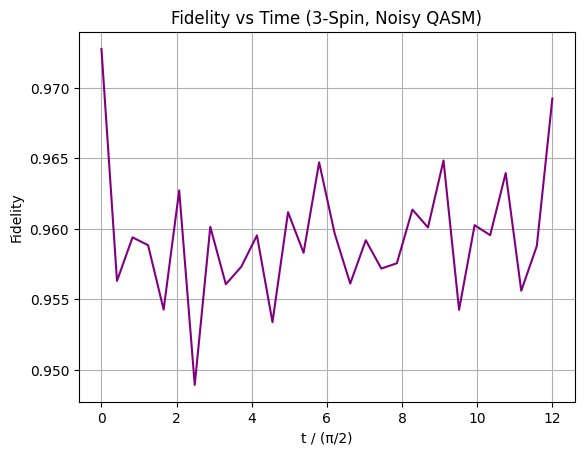

In [34]:
plt.plot(norm_times, fidelity_vs_time_3, color='purple')
plt.title('Fidelity vs Time (3-Spin, Noisy QASM)')
plt.xlabel('t / (π/2)')
plt.ylabel('Fidelity')
plt.grid(True)
plt.show()

This plot tracks how the **fidelity** between the ideal and noisy QASM simulation behaves as the 3-spin Heisenberg system evolves over time.

---

#### Key Observations:
- Fidelity begins relatively high (~0.97) at **t ≈ 0**, where the circuit is shallow and less exposed to noise.
- As time progresses, **fidelity generally decreases** and fluctuates more.
- These drops indicate increasing divergence between the noisy and ideal simulations — mainly due to:
  - **Deeper circuits** (from repeated interaction layers).
  - **Accumulated gate and measurement noise** in the backend model.

---

#### Interpretation:
- The **3-spin model** has more gates and longer circuit depth than the 2-spin system. This naturally leads to more opportunities for:
  - **Gate errors**
  - **Decoherence**
  - **Readout noise**
- Additionally, with more degrees of freedom, noise affects **state redistribution** more severely across the system.

---

#### Takeaway:
- **Fidelity drops faster and fluctuates more** in the 3-spin model compared to the 2-spin case.
- This demonstrates that simulating **larger quantum systems is more sensitive to noise**, even in simulation — an important insight for future hardware deployment.
---


## **Comparative Analysis:** 2-Spin vs 3-Spin Heisenberg Models (QASM Simulation)

This section summarizes and contrasts the 2-spin and 3-spin digital simulations of the Heisenberg model, focusing on **circuit structure, fidelity trends**, and **error behavior** under noisy QASM simulation using the `FakeSherbrooke` backend.

---

### 1. Circuit Structure & Complexity

| Feature                     | 2-Spin Model                        | 3-Spin Model                           |
|----------------------------|-------------------------------------|----------------------------------------|
| Qubits                     | 2                                   | 3                                      |
| Interaction Pairs          | 1 (qubits 0–1)                      | 2 (qubits 0–1 and 1–2)                 |
| Gate Count (per time step) | 3 entangling gates                  | 6 entangling gates                     |
| Depth Growth with Time     | Slower                              | Faster (deeper circuits)               |
| Hilbert Space Size         | 2² = 4 states                       | 2³ = 8 states                          |

---

### 2. Fidelity vs Time (Noisy QASM)

Fidelity was computed between ideal and noisy simulation results using the **Bhattacharyya coefficient** approximation:

| Metric                     | 2-Spin Model                        | 3-Spin Model                           |
|----------------------------|-------------------------------------|----------------------------------------|
| Time Range Simulated       | \(0 \rightarrow 2\pi\)              | \(0 \rightarrow 6\pi\)                 |
| Max Fidelity               | ~0.985                              | ~0.973                                 |
| Min Fidelity               | ~0.976                              | ~0.952                                 |
| Fluctuation Pattern        | Smooth, steady degradation          | Sharp drops and irregular spikes       |
| Trend                      | Slight downward slope               | Noisy, jagged, less predictable        |

**Interpretation**:
- 3-spin fidelity is **lower overall**, and **less stable**, due to:
  - More gates and deeper circuits (higher chance for errors).
  - Larger Hilbert space → more possible erroneous outcomes.
  - More paths for decoherence and noise to affect spin transfer.

---

### 3. Error Sources

| Error Type                | Common in Both | More Severe in 3-Spin | Explanation |
|---------------------------|----------------|------------------------|-------------|
| **Suzuki–Trotter Error**  | ✅              | ✅✅                    | Larger system = more interaction terms, more non-commuting exponentials. |
| **Gate Errors**           | ✅              | ✅✅                    | More gates per time step.             |
| **Readout Noise**         | ✅              | ✅✅                    | More qubits to measure → more error channels. |
| **Decoherence**           | ✅              | ✅✅                    | More qubits stay active longer.       |

---

### Key Takeaways

- **2-Spin Model**:
  - Clean swap oscillation behavior.
  - High fidelity maintained over time.
  - Limited by circuit depth only at longer time scales.

- **3-Spin Model**:
  - Spin excitation spreads in multiple directions → more complex interference.
  - Fidelity degrades **faster** and **less predictably**.
  - More prone to cumulative gate and readout errors.
---
>  **Conclusion**: The 3-spin model provides a more realistic simulation of many-body quantum systems, but also shows how **noise scales rapidly with system size**. Mitigating both **Trotter error** and **hardware noise** becomes critical for scaling simulations reliably.
---
